In [1]:
import mixmatch.models.wideresnet as models
from mixmatch.dataset.chestnut import ChestnutSubset, tf_preproc, tf_aug
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Sequence
from matplotlib import pyplot as plt
from seaborn import heatmap
import numpy as np
import pandas as pd
import torch
import os

# Count plot of labels

In [2]:
train_dataset_dir = "../chestnut_20201218_rgb_filtered_48"

In [3]:
data, keys = [], []
for species in os.listdir(train_dataset_dir):
    keys.append(species)
    data.append(len(os.listdir(os.path.join(train_dataset_dir, species))))
    print(f"{species} - {len(os.listdir(os.path.join(train_dataset_dir, species)))}")

Clausena Excavata - 14
Cinnamomum Iners - 32
Syzygium Polyanthum - 15
Falcataria Moluccana - 464
Ficus Variegata - 149
Alstonia Angulstiloba - 40
Bridelia Sp. - 132
Spathodea Campanulatum - 148
Sterculia Parviflora - 21


In [2]:
# importing libraries 
import matplotlib.pyplot as plt 
import seaborn 
  
# declaring exploding pie 
# explode = [0, 0.1, 0, 0, 0] 
# define Seaborn color palette to use 
palette_color = seaborn.color_palette('dark') 
  
# plotting data on chart 
_, _, autotexts = plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%') 
for autotext in autotexts:
    autotext.set_color('white')
  
# displaying chart 
plt.show() 

NameError: name 'data' is not defined

In [3]:
# load model
device = "cuda"
model = models.WideResNet(num_classes=9).to(device)
resume = "../Chestnut_logs/model_best.pth.tar"
checkpoint = torch.load(resume)
best_acc = checkpoint['best_acc']
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

# Confusion matrix

100%|██████████| 20/20 [00:00<00:00, 32.46it/s]


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'Clausena Excavata'),
  Text(1.5, 0, 'Cinnamomum Iners'),
  Text(2.5, 0, 'Syzygium Polyanthum'),
  Text(3.5, 0, 'Falcataria Moluccana'),
  Text(4.5, 0, 'Ficus Variegata'),
  Text(5.5, 0, 'Alstonia Angulstiloba'),
  Text(6.5, 0, 'Bridelia Sp.'),
  Text(7.5, 0, 'Spathodea Campanulatum'),
  Text(8.5, 0, 'Sterculia Parviflora')])

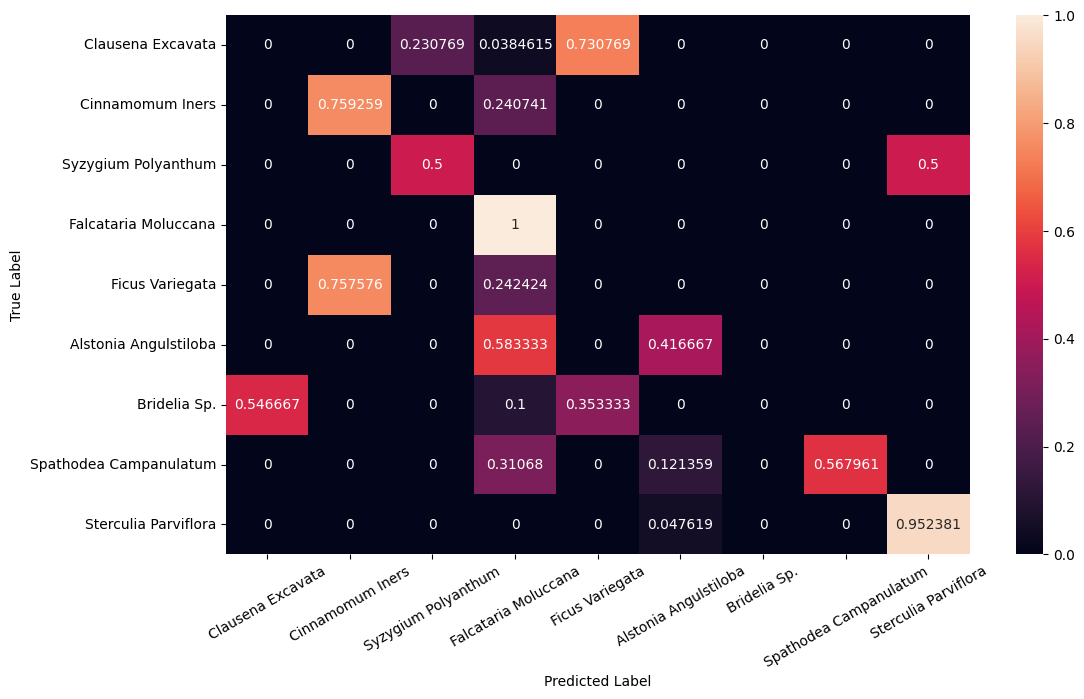

In [19]:
from sklearn.model_selection import train_test_split
from mixmatch.dataset.chestnut import ChestnutDataset, ChestnutSubsetKAug
home_dir = "chestnut_20210510_43m_filtered_48"
mean = [[[[0.4900003,  0.7561652,  0.6816349,  0.33079293, 0.2637088,  0.2194569, 0.44238895, 0.5651316]]]] 
std = [[[[0.1562084,  0.22682871, 0.21633616, 0.13870874, 0.14902467, 0.1258578, 0.17926748, 0.19278552]]]]
dl_args = dict(
    batch_size=64,
    num_workers=2,
)
test_ds = ChestnutSubset(
    root=f"../{home_dir}",
    transform=tf_preproc,
    stats=(mean, std),
)

test_dl = DataLoader(test_ds, shuffle=False, **dl_args)
y_trues, y_preds = [], []
logits = []
model.eval()
with torch.no_grad():
    for x, y in tqdm(test_dl):
        # TODO: Pretty hacky but this is for the train loader.
        if isinstance(x, Sequence):
            x = x[0]

        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)
        y_trues.append(y)
        y_preds.append(preds)
        logits.append(y_pred)

y_trues = torch.cat(y_trues)
y_preds = torch.cat(y_preds)
# Plot the confusion matrix
cm = confusion_matrix(y_trues.cpu().numpy(), y_preds.cpu().numpy())

df_cm = pd.DataFrame(cm, index = [i for i in test_ds.species_map],
                     columns = [i for i in test_ds.species_map])
df_final = df_cm.div(df_cm.sum(axis=1), axis=0)

plt.figure(figsize = (12,7))
heatmap(df_final, xticklabels=test_ds.species_map, yticklabels=test_ds.species_map, annot=True, fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=30)
        

# Grid mapping

In [31]:
from collections import defaultdict

test_dataset_dir = "../chestnut_20210510_43m_rgb_filtered_48"
species = "Spathodea Campanulatum"
size = 48

species_path = os.path.join(test_dataset_dir, species)
dims, cells = defaultdict(lambda: (-1, -1)), defaultdict(lambda: dict())
for fname in os.listdir(species_path):
    _split_name = fname.split("_")
    idx, i, j = int(_split_name[1]), int(_split_name[2]), int(_split_name[3][:-4])
    cell = np.load(os.path.join(species_path, fname))
    cells[idx][(i, j)] = cell
    max_x, max_y = max(i, dims[idx][0]), max(j, dims[idx][1])
    dims[idx] = (max_x, max_y)

imgs = {}
for idx, (n_r, n_c) in dims.items():
    img_arr = np.zeros(((n_r+1) * size, (n_c+1) * size, 3))
    for (i, j), cell in cells[idx].items():
        img_arr[i*size:(i+1)*size, j*size:(j+1)*size, :] = cell
    imgs[idx] = img_arr



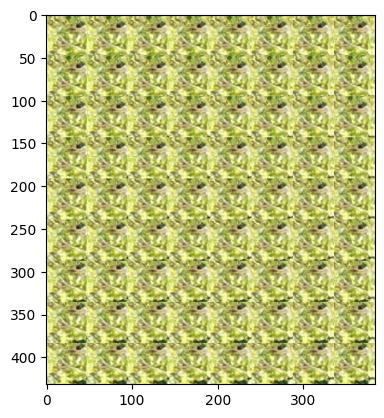

In [34]:
plt.imshow(imgs[5])

In [21]:
a = np.load("../chestnut_20210510_43m_rgb_filtered_48/Spathodea Campanulatum/Spathodea Campanulatum_5_0_2.npy")
b = np.load("../chestnut_20210510_43m_rgb_filtered_48/Spathodea Campanulatum/Spathodea Campanulatum_5_1_1.npy")
